# Genetic programming


In [1]:
import numpy as np
from deap import base, creator, gp, tools, algorithms
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import operator


In [2]:
# Inicia o individuo e a função de fitness
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)


In [3]:
# Adiciona os operadores permitidos
def power(x, y):
    return np.power(np.abs(x), np.abs(y))

n_x, n_y = 3, 3

pset = gp.PrimitiveSet(name="MAIN", arity=n_x+n_y)
pset.addPrimitive(np.add, arity=2)
pset.addPrimitive(np.subtract, arity=2)
pset.addPrimitive(np.multiply, arity=2)
# pset.addPrimitive(power, arity=2)
pset.addPrimitive(np.negative, arity=1)
pset.addPrimitive(np.cos, arity=1)
pset.addPrimitive(np.sin, arity=1)
pset.addEphemeralConstant("Constant", lambda: np.round(np.random.uniform(-10, 10), 2))


args = {f'ARG{n}':f'x{n}' for n in range(n_x)} | {f'ARG{n_x+n}':f'y{n}' for n in range(n_y)}

pset.renameArguments(**args)


In [4]:
pset.arguments

['x0', 'x1', 'x2', 'y0', 'y1', 'y2']

In [4]:
# Instância a população
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [5]:
# Retorna o erro
def evaluateRegression(individual, points: np.array, pset, fun):
    func = gp.compile(expr=individual, pset=pset)
    sqerrors = (func(points) - fun(points)) ** 2
    n = len(points)
    return (np.sqrt(np.sum(sqerrors) / n),)


In [6]:
def fun_alvo(x):
    return x**2 + 4 + np.sin(x**2) - np.cos(x) + x**3 - 0.1*x**4

In [7]:
points = np.arange(-10, 10, 0.01)

toolbox.register("evaluate", evaluateRegression, points=points, pset=pset, fun=fun_alvo)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=5)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.decorate(
    "mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10)
)
toolbox.decorate(
    "mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=10)
)


add(add(multiply(x, subtract(x, subtract(sin(negative(add(negative(7.52), add(1.74, x)))), multiply(cos(sin(sin(-6.3))), negative(sin(add(x, x))))))), add(add(subtract(5.75, add(sin(add(sin(4.85), add(multiply(x, 1.5), 6.53))), subtract(-4.42, negative(cos(x))))), 8.28), multiply(multiply(x, cos(negative(multiply(cos(-7.17), x)))), negative(add(x, subtract(add(x, cos(1.78)), negative(x))))))), add(add(multiply(add(subtract(sin(x), subtract(x, x)), add(multiply(x, -6.06), multiply(x, x))), x), 1.49), 1.49))
(17.780738196511336,)


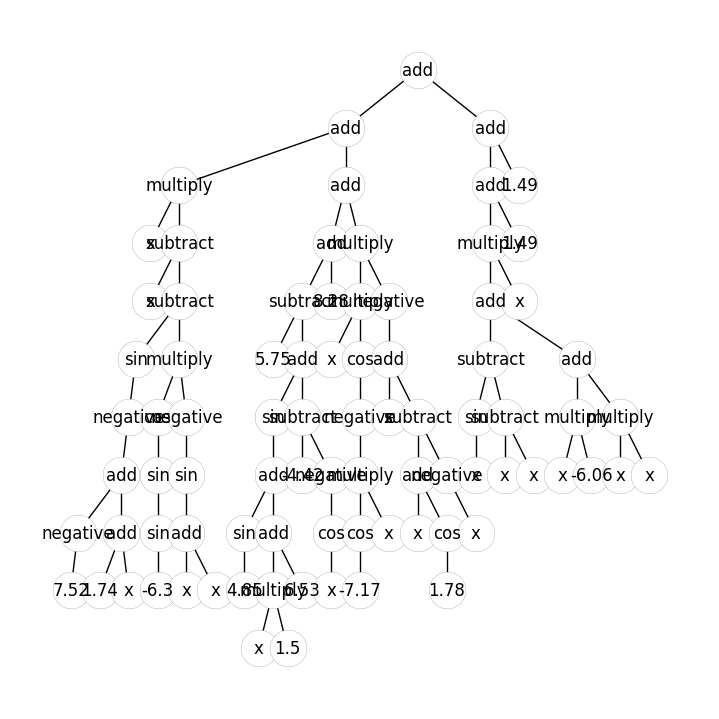

In [8]:
pop = toolbox.population(n=3000)
algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=100, verbose=False)
bests = tools.selBest(pop, k=1)
best = bests[0]
print(best)
print(best.fitness)
best_fun = gp.compile(best, pset)

nodes, edges, labels = gp.graph(best)
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

options = {
    "font_size": 30,
    "node_size": 700,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 0.1,
    "width": 1,
}

plt.figure(figsize=(7, 7))
nx.draw(graph, pos, **options)

nx.draw_networkx_labels(graph, pos, labels)
plt.show()


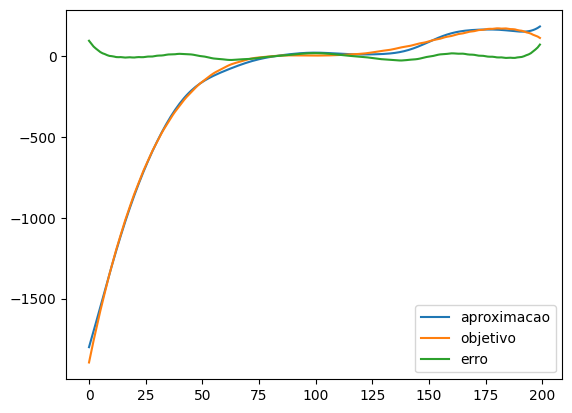

In [9]:
points_test = points = np.arange(-10, 10, 0.1)
aproximacao = best_fun(points_test)
objetivo = fun_alvo(points_test)
erro = aproximacao - objetivo

plt.figure()
sns.lineplot(data=aproximacao, label="aproximacao")
sns.lineplot(data=objetivo, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.close()


In [10]:
from copy import deepcopy as dc
bkp_best = dc(best)
print(bkp_best)

add(add(multiply(x, subtract(x, subtract(sin(negative(add(negative(7.52), add(1.74, x)))), multiply(cos(sin(sin(-6.3))), negative(sin(add(x, x))))))), add(add(subtract(5.75, add(sin(add(sin(4.85), add(multiply(x, 1.5), 6.53))), subtract(-4.42, negative(cos(x))))), 8.28), multiply(multiply(x, cos(negative(multiply(cos(-7.17), x)))), negative(add(x, subtract(add(x, cos(1.78)), negative(x))))))), add(add(multiply(add(subtract(sin(x), subtract(x, x)), add(multiply(x, -6.06), multiply(x, x))), x), 1.49), 1.49))


## Simplificando a árvore

In [11]:
def constantify(value, pset):
    code = f"lambda: {value}"
    new_value = np.round(eval(code, pset.context)(),2)

    new_constant = gp.Constant()
    new_constant.name = str(new_value)
    new_constant.value = new_value
    return new_constant


In [12]:
def all_constants(b, bs):
    if all(map(lambda x: isinstance(x, gp.Constant), bs)):
        code = b.format(*map(lambda x: x.value, bs))
        new_c = constantify(code, pset)
        # print(f"{code} = {new_c.value}")
        return new_c


def all_terminal(bs):
    return all(map(lambda x: isinstance(x, gp.Terminal), bs))


def add_n_negative2subtract(b, bs):
    if b.name != "add":
        return
    return bs[1].name == "negative"

def duple_negative(b, bs):
    return b.name == "negative" and bs[0] == "negative"

def arg_minus_arg(b, bs):
    return b.name == "subtract" and all_terminal(bs) and bs[0] == bs[1]

def zero_minus_anything(b, bs):
    if b.name != "subtract":
        return
    return all_terminal((bs[0],)) and bs[0].value == 0

def power_zero(b, bs):
    return b.name == 'power' and all_terminal((bs[1],)) and bs[1].value == 0

In [13]:
best = dc(bkp_best)

In [14]:
def simplify_tree():
    for i, b in enumerate(best):
        if isinstance(b,gp.Primitive):

            bs = []
            J = 1
            for _ in range(1, b.arity + 1):
                bs.append(best[i + J])
                J += len(best[best.searchSubtree(i+J)])

            if new_c := all_constants(b, bs):
                best.pop(i)
                best[i] = new_c

                for _ in range(1, b.arity):
                    best.pop(i + 1)
                return simplify_tree()
            
            if add_n_negative2subtract(b, bs):
                best[i] = pset.mapping['subtract']
                p = len(best[best.searchSubtree(i+1)])
                best.pop(i+p+1)
                return simplify_tree()
            
                
            if arg_minus_arg(b, bs):
                best.pop(i)
                best[i] = constantify('0', pset)

                for _ in range(1, b.arity):
                    best.pop(i + 1)

                return simplify_tree()
                    
            if zero_minus_anything(b, bs):
                print(i)
                print(best[i].name)
                best.pop(i)
                neg = pset.mapping['negative']
                neg.arity = 0
                best[i] = neg
                neg.arity = 1
                print(best[i].name)
                return simplify_tree()
            
            if power_zero(b, bs):
                best[best.searchSubtree(i)] = [constantify('1', pset)]
                return simplify_tree()
                
best = dc(bkp_best)
simplify_tree()


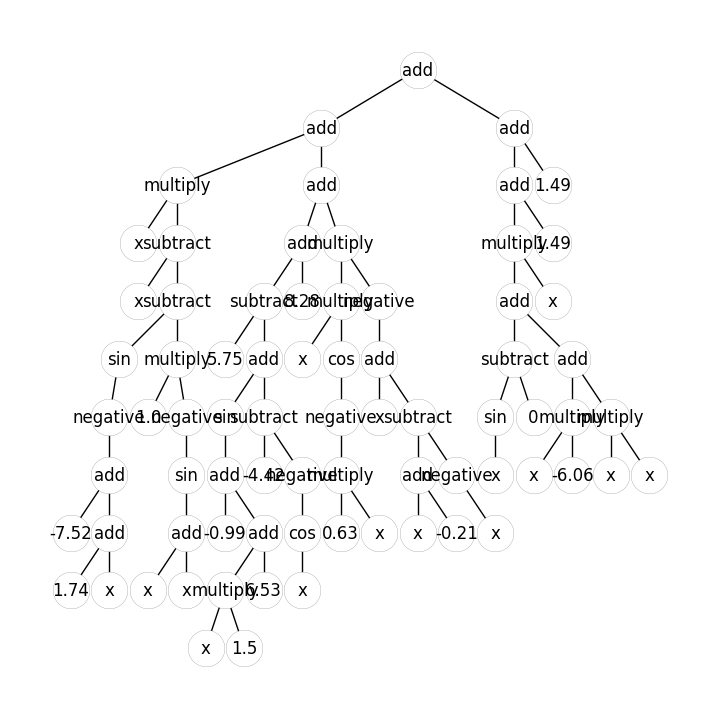

In [15]:
nodes, edges, labels = gp.graph(best)
graph = nx.Graph()
graph.add_nodes_from(nodes)
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")

options = {
    "font_size": 30,
    "node_size": 700,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 0.1,
    "width": 1,
}

plt.figure(figsize=(7, 7))
nx.draw(graph, pos, **options)

nx.draw_networkx_labels(graph, pos, labels)
plt.show()

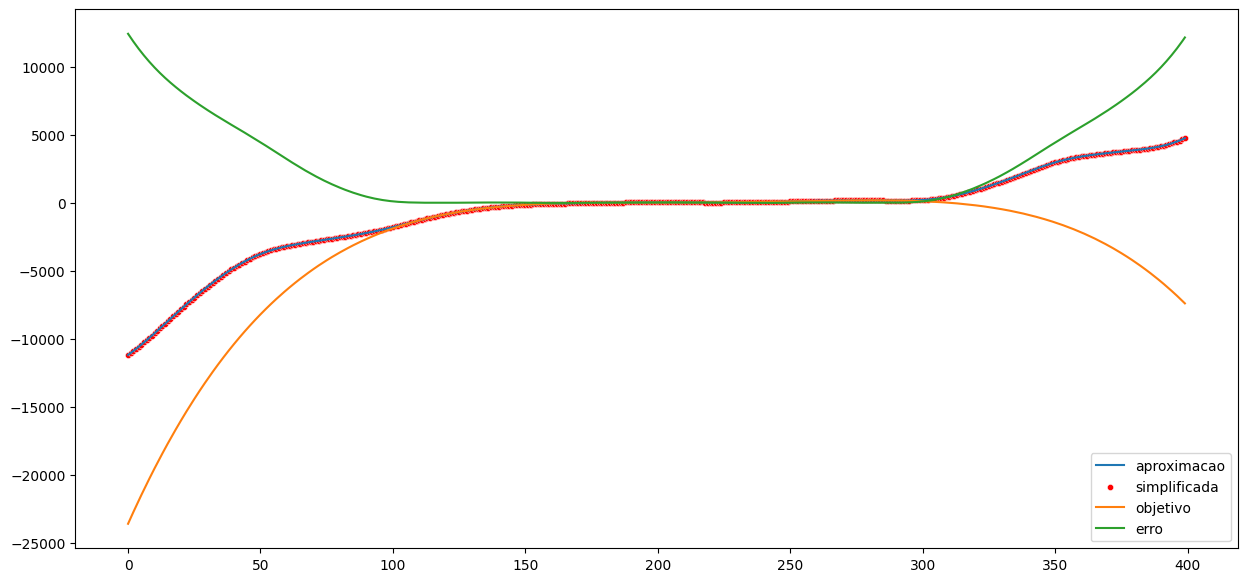

In [16]:
points_test = points = np.arange(-20, 20, 0.1)
aproximacao = best_fun(points_test)
objetivo = fun_alvo(points_test)
best_simp = gp.compile(best, pset)
aproximacao2 = best_fun(points_test)
erro = aproximacao - objetivo

plt.figure(figsize=(15,7))
sns.lineplot(data=aproximacao, label="aproximacao")
sns.scatterplot(data=aproximacao2, label="simplificada", color='red', markers='.', s=20)
sns.lineplot(data=objetivo, label="objetivo")
sns.lineplot(data=erro, label="erro")
plt.show()
plt.grid()
plt.close()
